In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
import os
from utils.SHIPS_preprocess import SHIPS_train_test_split, calc_d24_VMAX, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS
from utils.SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes
from utils.SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_RF
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_RF, get_scores_best_params_RF, create_gridsearch_RF, get_train_test_split
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_LR, get_scores_best_params_LR, create_gridsearch_LR, get_feature_importances_LR
from utils.SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score,brier_score_loss
from sklearn.inspection import permutation_importance
import matplotlib.colors
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from utils.SHIPS_ML_model_funcs_imblearn import create_gridsearch_RF_sampler
from utils import SHIPS_plotting
import pickle

##### Model evaluation

In [3]:
def evaluate_model_RF(model,X_test,y_test,basin,fold,model_name,test_years,label_names,ncats,scoring):
    # Classification report
    report, y_true, y_pred = get_scores_best_params_RF(model,X_test,y_test,basin)
    report['Years Out'] = str(test_years)
    report['Model'] = model_name
    report['Fold'] = i
    # Confusion matrix
    cm_stats = get_confusion_matrix_RF(model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Years Out'] = str(test_years)
    cm_stats['Model'] = model_name
    cm_stats['Fold'] = i
    # Feature importances
    fi_pred = get_feature_importances_RF(model,X_test,y_test,basin,scoring)
    fi_pred['Years Out'] = str(test_years)
    fi_pred['Model'] = model_name
    fi_pred['Fold'] = i
    # ROC curve / AUC scores
    ypred_prob, p_vs_r, roc_vals, brier_loss, bs_ref = get_roc_auc(X_test,basin,model,y_test,1,'R1',scoring,'equal')
    p_vs_r['Years Out'] = str(test_years)
    p_vs_r['Model'] = model_name
    p_vs_r['Fold'] = i
    roc_vals['Fold'] = i
    roc_vals['Model'] = model_name
    roc_vals['Years Out'] = str(test_years)
    # Get actual predictions of target variable Y
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    # Save predicted values of y
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = model_name
    # Get probabilities for 0 (not-RI) and 1 (RI)
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    #
    return y_pred_all,roc_vals,p_vs_r,fi_pred,cm_stats,report

##### Model evaluation--logistic regression

In [4]:
def evaluate_model_LR(model,X_test,y_test,basin,fold,model_name,test_years,label_names,ncats,scoring):
    # Classification report
    report, y_true, y_pred = get_scores_best_params_LR(model,X_test,y_test,basin)
    report['Years Out'] = str(test_years)
    report['Model'] = model_name
    report['Fold'] = i
    # Confusion matrix
    cm_stats = get_confusion_matrix_LR(model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Years Out'] = str(test_years)
    cm_stats['Model'] = model_name
    cm_stats['Fold'] = i
    # Feature importances
    fi_pred = get_feature_importances_LR(model,X_test,y_test,basin,scoring)
    fi_pred['Years Out'] = str(test_years)
    fi_pred['Model'] = model_name
    fi_pred['Fold'] = i
    # ROC curve / AUC scores
    ypred_prob, p_vs_r, roc_vals = get_roc_auc(X_test,basin,model,y_test,1,'R1',scoring,'equal')
    p_vs_r['Years Out'] = str(test_years)
    p_vs_r['Model'] = model_name
    p_vs_r['Fold'] = i
    roc_vals['Fold'] = i
    roc_vals['Model'] = model_name
    roc_vals['Years Out'] = str(test_years)
    # Get actual predictions of target variable Y
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    # Save predicted values of y
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = model_name
    # Get probabilities for 0 (not-RI) and 1 (RI)
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    #
    return y_pred_all,roc_vals,p_vs_r,fi_pred,cm_stats,report

##### Load experiments

In [5]:
fpath_load = 'DATA/ML_model_results/TRAINING/all_models_ROS_and_SMOTE/'
train_yr_start = 2005
train_yr_end = 2018
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'
N_samples = 25

#### Load Confusion Matrix, precision vs recall

In [6]:
path_suff = 'TRAIN_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_MASK_{stand_str}_RI_thresh_{RI_thresh}'\
'_{N}_samples_{scoring}.csv'.format(yr_start=train_yr_start,yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,N=N_samples,scoring=score)
cm_res = pd.read_csv(fpath_load+'Conf_Matrix'+path_suff)

In [7]:
cm_res.groupby(['Model','BASIN','Fold']).count()

Unnamed: 0  Misses  SR  \
Model                             BASIN        Fold                           
Logistic Reg.                     ALL          0              2       2   2   
                                               1              2       2   2   
                                               2              2       2   2   
                                               3              2       2   2   
                                               4              2       2   2   
...                                                         ...     ...  ..   
Random Forest (random oversample) WEST_PACIFIC 20             2       2   2   
                                               21             2       2   2   
                                               22             2       2   2   
                                               23             2       2   2   
                                               24             2       2   2   

                                                     Category Names  \
Model                             BASIN        Fold                   
Logistic Reg.                     ALL          0                  2   
                                               1                  2   
                                               2                  2   
                                               3                  2   
                                               4                  2   
...                                                             ...   
Random Forest (random oversample) WEST_PACIFIC 20                 2   
                                               21                 2   
                                               22                 2   
                                               23                 2   
                                               24                 2   

                                                     N_predicted  PFOD  \
Model                             BASIN        Fold                      
Logistic Reg.                     ALL          0               2     2   
                                               1               2     2   
                                               2               2     2   
                                               3               2     2   
                                               4               2     2   
...                                                          ...   ...   
Random Forest (random oversample) WEST_PACIFIC 20              2     2   
                                               21              2     2   
                                               22              2     2   
                                               23              2     2   
                                               24              2     2   

                                                     Category  Threat  \
Model                             BASIN        Fold                     
Logistic Reg.                     ALL          0            2       2   
                                               1            2       2   
                                               2            2       2   
                                               3            2       2   
                                               4            2       2   
...                                                       ...     ...   
Random Forest (random oversample) WEST_PACIFIC 20           2       2   
                                               21           2       2   
                                               22           2       2   
                                               23           2       2   
                                               24           2       2   

                                                     N_actual  POD  ...  FAR  \
Model                             BASIN        Fold                 ...        
Logistic Reg.               

##### Identify best model parameters
There are a lot of ways to do this. We select the best model based on `CSI` (but you could use a different metric if you wanted, like best `PoD`, lowest `FAR`, highest `recall`, etc.).  We select the model that performs best on our all-basin predictions (but again, could make a different choice)

In [8]:
cm_max_threat = cm_res.set_index(['Category Names','BASIN','Model']).sort_values(by=['BASIN','Model','Threat'],
                                                                                ascending=[True,True,False])
basin_ALL = cm_res['BASIN'].unique().tolist()
cm_max_best = pd.DataFrame()
for ibasin in basin_ALL:
    icm = cm_max_threat.drop(columns={'Unnamed: 0','Category'}).xs(('RI',ibasin)).iloc[np.arange(0,100,25)]
    icm['BASIN'] = ibasin
    cm_max_best = cm_max_best.append(icm.reset_index(),ignore_index=True)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


#### Load SHIPS predictors

In [9]:
def load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin='ALL'):
    SHIPS_predictors = pd.DataFrame()
    fpath_load = 'DATA/processed/'
    if use_basin == 'ALL':
        BASIN = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
    else:
        BASIN = [use_basin]
    #
    for i_name in BASIN:
        fname_load = fpath_load+'SHIPS_processed_{BASIN}_set_yrs_{yr_start}-{yr_end}_max_fore_hr_{max_fore}_{interp_str}_'\
        'land_mask_{mask_TYPE}.csv'.format(BASIN=i_name,yr_start=yr_start,yr_end=yr_end,
                                          max_fore=max_fore,interp_str=interp_str,mask_TYPE=mask_TYPE)
        iload = pd.read_csv(fname_load)
        # Change RSST / RHCN to NSST / NOHC just to keep naming consistent
        if (i_name != 'ATLANTIC') | (i_name != 'EAST_PACIFIC'):
            iload = iload.rename(columns={'RSST':'NSST','RHCN':'NOHC'})
        #
        iload['BASIN'] = i_name
        SHIPS_predictors = SHIPS_predictors.append(iload)
        #
    SHIPS_predictors = SHIPS_predictors.drop(columns={'level_0','index'})
    return SHIPS_predictors,BASIN

In [10]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_end_LOAD = 2021
yr_end_TRAIN = 2018
use_basin = 'ALL'

SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end_LOAD,mask_TYPE,max_fore,interp_str,use_basin)
#
FULL_yrs = np.arange(yr_start,yr_end_LOAD+1,1)
SHIPS_predictors = SHIPS_predictors[pd.to_datetime(SHIPS_predictors['DATE_full']).dt.year.isin(FULL_yrs)]

#### Train best-guess ML model
We'll construct the best-guess ML model from our optimal hyperparameters, identified above. We'll train the model once on our entire training period, 2005-2018

Identify best parameters

In [11]:
cm_max_sel = cm_max_best.set_index(['BASIN','Model']).xs('ALL')
C_vals = [cm_max_sel.xs('Logistic Reg.')['C']]
max_iter = [cm_max_sel.xs('Logistic Reg.')['Max Iter'].astype(int)]
#
cw_max_depth = [cm_max_sel.xs('Random Forest (class wt)')['Max Depth'].astype(int)]
cw_max_feat = [cm_max_sel.xs('Random Forest (class wt)')['Max Features'].astype(int)]
cw_n_est = [cm_max_sel.xs('Random Forest (class wt)')['N Estimators'].astype(int)]
cw_min_samp_leaf = [cm_max_sel.xs('Random Forest (class wt)')['Min Samples Leaf'].astype(int)]
#
smote_max_depth = [cm_max_sel.xs('Random Forest (SMOTE)')['Max Depth'].astype(int)]
smote_max_feat = [cm_max_sel.xs('Random Forest (SMOTE)')['Max Features'].astype(int)]
smote_n_est = [cm_max_sel.xs('Random Forest (SMOTE)')['N Estimators'].astype(int)]
smote_min_samp_leaf = [cm_max_sel.xs('Random Forest (SMOTE)')['Min Samples Leaf'].astype(int)]
#
ov_max_depth = [cm_max_sel.xs('Random Forest (random oversample)')['Max Depth'].astype(int)]
ov_max_feat = [cm_max_sel.xs('Random Forest (random oversample)')['Max Features'].astype(int)]
ov_n_est = [cm_max_sel.xs('Random Forest (random oversample)')['N Estimators'].astype(int)]
ov_min_samp_leaf = [cm_max_sel.xs('Random Forest (random oversample)')['Min Samples Leaf'].astype(int)]


In [12]:
cm_res.groupby(['Model','BASIN','Fold']).count()
#cw_max_feat

Unnamed: 0  Misses  SR  \
Model                             BASIN        Fold                           
Logistic Reg.                     ALL          0              2       2   2   
                                               1              2       2   2   
                                               2              2       2   2   
                                               3              2       2   2   
                                               4              2       2   2   
...                                                         ...     ...  ..   
Random Forest (random oversample) WEST_PACIFIC 20             2       2   2   
                                               21             2       2   2   
                                               22             2       2   2   
                                               23             2       2   2   
                                               24             2       2   2   

                                                     Category Names  \
Model                             BASIN        Fold                   
Logistic Reg.                     ALL          0                  2   
                                               1                  2   
                                               2                  2   
                                               3                  2   
                                               4                  2   
...                                                             ...   
Random Forest (random oversample) WEST_PACIFIC 20                 2   
                                               21                 2   
                                               22                 2   
                                               23                 2   
                                               24                 2   

                                                     N_predicted  PFOD  \
Model                             BASIN        Fold                      
Logistic Reg.                     ALL          0               2     2   
                                               1               2     2   
                                               2               2     2   
                                               3               2     2   
                                               4               2     2   
...                                                          ...   ...   
Random Forest (random oversample) WEST_PACIFIC 20              2     2   
                                               21              2     2   
                                               22              2     2   
                                               23              2     2   
                                               24              2     2   

                                                     Category  Threat  \
Model                             BASIN        Fold                     
Logistic Reg.                     ALL          0            2       2   
                                               1            2       2   
                                               2            2       2   
                                               3            2       2   
                                               4            2       2   
...                                                       ...     ...   
Random Forest (random oversample) WEST_PACIFIC 20           2       2   
                                               21           2       2   
                                               22           2       2   
                                               23           2       2   
                                               24           2       2   

                                                     N_actual  POD  ...  FAR  \
Model                             BASIN        Fold                 ...        
Logistic Reg.               

In [13]:
hrs_max = 24
# Features to drop before ML model
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True
# Cross-val
k_folds = 10
n_repeats = 3
fig_format = 'png'
#
# Logistic
solver = 'lbfgs'
if (solver == 'saga'):
    penalty = 'l1'
else: 
    penalty = 'l2'

In [14]:
ncats = 2
to_predict = 'I_class'
scoring = 'f1_weighted'
cut = 'equal'
sampler = SMOTE(sampling_strategy = 0.9)
sampler_str = 'over'
sampler2 = [RandomOverSampler(sampling_strategy = 0.9)]
sampler_str2 = ['over']
sampler_str_ALL = [sampler_str]#,sampler_str2]
sampler_ALL = [sampler]#,sampler2]
#
# FULL_yrs = np.arange(yr_start,yr_end_TRAIN,1)
use_custom_wts = False
wts_sel = 0
n_valid = 3
score = ['gini']
label_names = ['not RI','RI']
BASIN_all = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTHERN_HEM','ALL']
# Loop through bootstrapping examples

In [15]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()
# 

In [16]:
# Split data into training/validation
test_years = [2019,2020,2021] # years we will use for validation
X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)
# Set up hyperparameter sweeps
RF_model_ov = create_gridsearch_RF_sampler(is_standard,score,smote_max_depth,smote_n_est,smote_max_feat,smote_min_samp_leaf,
                            k_folds,n_repeats,scoring,sampler_ALL,sampler_str_ALL)
#
RF_model_ROS = create_gridsearch_RF_sampler(is_standard,score,ov_max_depth,ov_n_est,ov_max_feat,ov_min_samp_leaf,
                            k_folds,n_repeats,scoring,sampler2,sampler_str2)
#
RF_model = create_gridsearch_RF(is_standard,score,cw_max_depth,cw_n_est,cw_max_feat,cw_min_samp_leaf,
                            k_folds,n_repeats,use_custom_wts,wts_sel,scoring)
# 
LR_model = create_gridsearch_LR(is_standard,solver,penalty,C_vals,max_iter,k_folds,n_repeats,
                                use_custom_wts,wts_sel,scoring,no_wts=False)
#
print('fitting models')
LR_model.fit(X_train,y_train['I_class'])
RF_model.fit(X_train,y_train['I_class'])
RF_model_ov.fit(X_train,y_train['I_class'])
RF_model_ROS.fit(X_train,y_train['I_class'])

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


averaging hours together
fitting models


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('over',
                                        RandomOverSampler(sampling_strategy=0.9)),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'clf__criterion': ['gini'], 'clf__max_depth': [11],
                         'clf__max_features': [4],
                         'clf__min_samples_leaf': [10],
                         'clf__n_estimators': [250]},
             scoring='f1_weighted')

running  WEST_PACIFIC


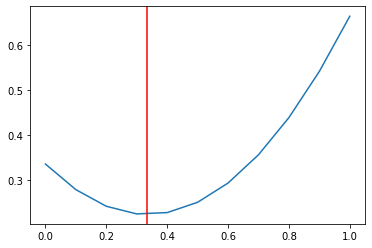

In [39]:
# Now get scores for each basin
i = 0
#print('validating models')
#for basin in BASIN_all:
basin = 'WEST_PACIFIC'
print('running ',basin)
#ypred_prob, p_vs_r, roc_vals, brier_loss, bs_ref = get_roc_auc(X_test,basin,RF_model_ov,y_test,1,'R1',scoring,'equal')
#
class_sel = 1
class_label = 'RI'
if basin == 'ALL':
    ypred_prob = RF_model_ov.predict_proba(X_test)
    y_test_use = y_test['I_class']
else:
    ypred_prob = RF_model_ov.predict_proba(X_test.xs(basin))
    y_test_use = y_test['I_class'].xs(basin)
# Everything for RI only
y_scores_RI = ypred_prob[:,class_sel]
# Get Brier Skill Score
brier_loss = [brier_score_loss(y_test_use,[y for x in range(len(y_test_use))]) for y in np.arange(0,1.01,0.1)]
BS_ref = np.sum(y_test_use==1)/len((y_test_use))
brier_loss
#BS_ref
plt.plot(np.arange(0,1.01,0.1),brier_loss)
plt.axvline(BS_ref,color='r')

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
y_pred_all_RF_OV,roc_vals_RF_OV,p_vs_r_RF_OV,fi_pred_RF_OV,cm_stats_RF_OV,report_RF_OV = evaluate_model_RF(RF_model_ov,
                      X_test,y_test,basin,i,'Random Forest (SMOTE)',test_years,label_names,ncats,scoring)
# 
y_pred_all_ROS,roc_vals_ROS,p_vs_r_ROS,fi_pred_ROS,cm_stats_ROS,report_ROS = evaluate_model_RF(RF_model_ROS,
                      X_test,y_test,basin,i,'Random Forest (random oversample)',test_years,label_names,ncats,scoring)
#
y_pred_all_RF,roc_vals_RF,p_vs_r_RF,fi_pred_RF,cm_stats_RF,report_RF = evaluate_model_RF(RF_model,
                      X_test,y_test,basin,i,'Random Forest (class wt)',test_years,label_names,ncats,scoring)
# 
y_pred_all_LR,roc_vals_LR,p_vs_r_LR,fi_pred_LR,cm_stats_LR,report_LR = evaluate_model_LR(LR_model,
                      X_test,y_test,basin,i,'Logistic Reg.',test_years,label_names,ncats,scoring)
# 
y_pred_all = pd.concat([y_pred_all_RF_OV,y_pred_all_ROS,y_pred_all_RF,y_pred_all_LR])
predicted_y_ALL = predicted_y_ALL.append(y_pred_all)
# 
roc_vals = pd.concat([roc_vals_RF,roc_vals_ROS,roc_vals_RF_OV,roc_vals_LR])
roc_vals_ALL = roc_vals_ALL.append(roc_vals)
#
pvr = pd.concat([p_vs_r_RF_OV,p_vs_r_ROS,p_vs_r_RF,p_vs_r_LR])
p_vs_r_ALL = p_vs_r_ALL.append(pvr)
# 
fi_pred = pd.concat([fi_pred_RF_OV,fi_pred_ROS,fi_pred_RF,fi_pred_LR])
fi_pred_ALL = fi_pred_ALL.append(fi_pred)
#
cm_stats = pd.concat([cm_stats_RF_OV,cm_stats_ROS,cm_stats_RF,cm_stats_LR])
cm_ALL = cm_ALL.append(cm_stats)
#
report = pd.concat([report_RF_OV,report_ROS,report_RF,report_LR])
report_ALL = report_ALL.append(report)

#### Test best-guess model on 2019-2021 

In [ ]:
sns.stripplot(data=cm_ALL.set_index(['Category Names','BASIN','Model']).xs('RI').reset_index(),
            x='BASIN',y='Threat',hue='Model')

#### Save results (inc. trained model)

In [ ]:
save_dir = 'DATA/ML_model_results/TESTING/'
model_type = 'all_models_ROS_and_SMOTE'
save_dir = save_dir+model_type+'/'
save_extension = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=yr_start,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)
save_ext_figs = 'TEST_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.png'.format(yr_start=yr_start,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)

##### Create subdirectories if they don't exist

In [ ]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# figs directory
if not os.path.exists(save_dir+'/figs/'):
    os.makedirs(save_dir+'/figs/')

In [ ]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
print('saved y vals')
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
print('saved ROC vals')
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
print('saved precision / recall values')
fi_pred_ALL.to_csv(save_dir+'Feat_Imp_validation'+save_extension)
print('saved feat importances')
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN'+save_extension)
print('saved feat importances (training)')
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
print('saved confusion matrix')
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)
print('saved classification report ',save_dir+'Class_Report'+save_extension)

In [ ]:
LR_model_fname = save_dir+'LOGISTIC_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
RF_cw_model_fname = save_dir+'RF_class_wt_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
RF_ov_model_fname = save_dir+'RF_oversamp_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
RF_smote_model_fname = save_dir+'RF_smote_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
#
pickle.dump(LR_model,open(LR_model_fname,'wb'))
pickle.dump(RF_model,open(RF_cw_model_fname,'wb'))
pickle.dump(RF_model_ov,open(RF_smote_model_fname,'wb'))
pickle.dump(RF_model_ROS,open(RF_ov_model_fname,'wb'))



In [ ]:
loaded_model = pickle.load(open(LR_model_fname, 'rb'))
result = loaded_model.score(X_test, y_test['I_class'])

In [ ]:
result

In [ ]:
LR_model.best_estimator_.params()